In [ ]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import ast
from concurrent.futures import ThreadPoolExecutor
import itertools
import time
from random import randint
import numpy as np
from random import uniform, randint
import random
import numpy as np
import re
#import cloudscraper
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! pip install cloudscraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 4.7 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 


1. Получение данных (Парсинг сайта)

In [ ]:
def flatten_list(two_dim_list): # превращение двумерного списка в одномерный
    ordinary_list = list(itertools.chain(*two_dim_list))
    ordinary_list = list(set(ordinary_list))
    return ordinary_list

In [ ]:
def get_proxies():  # получение бесплатных прокси
    proxies_hd = []
    for page in ['32', '64', '129']:
        url = "https://hidemy.name/en/proxy-list/?maxtime=1600&type=hs&anon=34&start="+page+"#list"
        site = requests.get(url, headers = headers)
        html = BS(site.content, 'html.parser').find('div', class_ = "table_block").find_all('tr')
        proxies_hd.append([html[page_n].find_all('td')[0].text+':'+html[page_n].find_all('td')[1].text for page_n in range(len(html)) if page_n > 0])

    url = "https://free-proxy-list.net/"
    site = requests.get(url, headers = headers)
    html = BS(site.content, 'html.parser').find('div', class_ = "table-responsive fpl-list").find_all('tr')
    proxies_levels = []
    for columns in html[1:]:
        data = columns.find_all('td')
        proxies_levels.append(np.array([data[0].text+':'+data[1].text, data[4].text]))
    proxies_levels = np.array(proxies_levels)
    df_proxy = pd.DataFrame({'ip': proxies_levels[:, 0], 'anonymity': proxies_levels[:, 1]})
    proxy_anon  = df_proxy[df_proxy != 'transparent'].values[:, 0]
    proxies = pd.read_csv('Free_Proxy_List.csv', delimiter=';')
    proxies["IP ADDRESS"] = proxies["IP ADDRESS"].astype(str)
    proxies["PORT"] = proxies["PORT"].astype(str)
    proxies_read = (proxies["IP ADDRESS"]+":"+proxies["PORT"].apply(lambda x: x.split('.')[0])).values
    proxy = list(set(flatten_list(proxies_hd)+list(proxy_anon)+list(proxies_read)))
    proxy = list(set(flatten_list(proxies_hd)+list(proxy_anon)))
    return proxy

In [ ]:
GLOBAL_URL = "https://www.cian.ru"  # сайт
headers = {
    'authority': 'https://www.google.com/',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'referer': 'https://www.google.com/',
    'accept-language': 'ru-RU, ru;q=0.9',
}

proxies = get_proxies()
information = ['Сколько комнат', 'Площадь', 'Год постройки', 'Этаж', 'Сколько всего этажей', 'Ближайшее метро', 'Расстояние до метро', 'Отделка', 'Тип жилья', 'Ремонт', 'Планировка', 'Вид из окна', 'Цена', 'Ссылка', 'Active']

In [ ]:
def acceleration_executor(function, array, parameters=False, df=False): # ускорение парсинга с помощью параллельных вычислений
    links = []
    if parameters:
        with ThreadPoolExecutor() as executor:
            links =  list(executor.map(function, array, *parameters))
    else:
         with ThreadPoolExecutor() as executor:
            links =  list(executor.map(function, array))
    if df:
        return pd.DataFrame(links)
    else:      
        return flatten_list(links)

In [ ]:
def get_protected_request(link, proxies = proxies, headers = headers, sleep=False): # Отправка защищенного запроса на сервер
     x = randint(0,len(proxies)-1)
     request = requests.get(link, headers = headers, proxies = {"http": "http://"+proxies[x], "http": "http://"+proxies[x]})
     if sleep:
         x = uniform(0,2)
         time.sleep(x)
     return request

In [ ]:
def get_links(main_page): # получение всех ссылок
    catalog = get_protected_request(link = main_page, sleep = bool(random.choice([0,1,2])))
    html_refs = BS(catalog.content, 'html.parser')
    refs_html = html_refs.find_all('div', class_ = "_93444fe79c--container--kZeLu _93444fe79c--link--DqDOy")
    refs = [ref.find('a').get('href') for ref in refs_html]
    return refs

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'
}
requests.get('https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=2&region=1', headers = headers)

<Response [503]>

In [ ]:
scraper = cloudscraper.create_scraper()
scraper.get('https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=3&region=1',headers = headers)

In [ ]:
def get_product_data(link): # Функция для обработки объявления
    try:
        attributes = {key: '' for key in information}
        attributes['Ссылка'] = link
        html = BS(get_protected_request(link).content, 'html.parser')
        header = html.find('h1', class_ = "a10a3f92e9--title--UEAG3").text        
        try:
            attributes['Сколько комнат'] = int(re.search('\d{1,2}-комн.', header, re.UNICODE)[0][0])
        except:
            attributes['Сколько комнат'] = header.split(',')[0]
        square_string = re.search('(\d+ )?\d{1,5},?\d+ м²', header, re.UNICODE)[0].split(' ')[:-1]
        attributes['Площадь'] = float(''.join(square_string).replace(',','.'))
        sum_values = html.find_all('div', class_ = "a10a3f92e9--info-value--bm3DC")
        sum_title = html.find_all('div', class_ = "a10a3f92e9--info-title--JWtIm")
        summary_description = {title.text: val.text for val,title  in zip(sum_values, sum_title)}
        year = summary_description.get('Построен', '')
        if year:
            attributes['Год постройки'] = int(year)
        attributes['Отделка'] = summary_description.get('Отделка', 'Чистовая')
        floor = summary_description.get('Этаж', '')

        if floor:
            floor = floor.split()
            attributes['Этаж'] = int(floor[0])
            attributes['Сколько всего этажей'] = int(floor[-1])

        underground_html = html.find('li', class_ = "a10a3f92e9--underground--wH2F4")
        if underground_html:
            underground =  underground_html.text.split('⋅')     
            if len(underground) > 1:
                attributes['Ближайшее метро'] = underground[0][:-1]
                attributes['Расстояние до метро'] = underground[1][2:]
            else:
                attributes['Ближайшее метро'] = underground[0]

        names_add_info = html.find_all('span', class_ = "a10a3f92e9--name--x7_lt")
        values_add_info = html.find_all('span', class_ = "a10a3f92e9--value--Y34zN")
        additional_info = {key.text: value.text for key, value in zip(names_add_info, values_add_info) if key.text in information}
        add_keys = ['Тип жилья', 'Ремонт', 'Планировка', 'Вид из окна']

        for key in add_keys:
            attributes[key] = additional_info.get(key, '')
        price_span = html.find('span', class_ = "a10a3f92e9--price_value--lqIK0").find('span')
        attributes['Цена'] =  int('_'.join(price_span['content'].split()[:-1]))
        attributes['Active'] = 1-bool(html.find('div', class_ ="a10a3f92e9--container--RXoIe"))
    except:
        print(link)
    return attributes


In [ ]:
get_product_data("https://www.cian.ru/sale/flat/280268258/")

{'Сколько комнат': 4,
 'Площадь': 108.45,
 'Год постройки': '',
 'Этаж': 6,
 'Сколько всего этажей': 6,
 'Ближайшее метро': 'Технопарк',
 'Расстояние до метро': '5 мин. пешком',
 'Отделка': 'Без отделки',
 'Тип жилья': 'Новостройка',
 'Ремонт': '',
 'Планировка': '',
 'Вид из окна': '',
 'Цена': 63039395,
 'Ссылка': 'https://www.cian.ru/sale/flat/280268258/',
 'Active': 1}

In [ ]:
def check(link):
    attributes = {key: '' for key in information}
    attributes['Ссылка'] = link
    html = BS(get_protected_request(link).content, 'html.parser')
    header = html.find('h1', class_ = "a10a3f92e9--title--UEAG3").text
    try:
        attributes['Сколько комнат'] = int(re.search('\d{1,2}-комн.', header, re.UNICODE)[0][0])
    except:
        attributes['Сколько комнат'] = header.split(',')[0]
    square_string = re.search('(\d+ )?\d{1,5},?\d+ м²', header, re.UNICODE)[0].split(' ')[:-1]
    attributes['Площадь'] = float(''.join(square_string).replace(',','.'))
    sum_values = html.find_all('div', class_ = "a10a3f92e9--info-value--bm3DC")
    sum_title = html.find_all('div', class_ = "a10a3f92e9--info-title--JWtIm")
    summary_description = {title.text: val.text for val,title  in zip(sum_values, sum_title)}
    year = summary_description.get('Построен', '')
    if year:
        attributes['Год постройки'] = int(year)
    attributes['Отделка'] = summary_description.get('Отделка', 'Чистовая')
    floor = summary_description.get('Этаж', '')
    if floor:
        floor = floor.split()
        attributes['Этаж'] = int(floor[0])
        attributes['Сколько всего этажей'] = int(floor[-1])

    underground_html = html.find('li', class_ = "a10a3f92e9--underground--wH2F4")
    if underground_html:
        underground =  underground_html.text.split('⋅')
        attributes['Ближайшее метро'] = underground[0][:-1]
        if len(underground) > 1:
            attributes['Ближайшее метро'] = underground[0][:-1]
            attributes['Расстояние до метро'] = underground[1][2:]
        else:
            attributes['Ближайшее метро'] = underground[0]
    names_add_info = html.find_all('span', class_ = "a10a3f92e9--name--x7_lt")
    values_add_info = html.find_all('span', class_ = "a10a3f92e9--value--Y34zN")
    additional_info = {key.text: value.text for key, value in zip(names_add_info, values_add_info) if key.text in information}
    add_keys = ['Тип жилья', 'Ремонт', 'Планировка', 'Вид из окна']
    for key in add_keys:
        attributes[key] = additional_info.get(key, '')
    price_span = html.find('span', class_ = "a10a3f92e9--price_value--lqIK0").find('span')
    attributes['Цена'] =  int('_'.join(price_span['content'].split()[:-1]))
    attributes['Active'] = 1-bool(html.find('div', class_ ="a10a3f92e9--container--RXoIe"))
    return attributes

In [ ]:
page_links = [f'{GLOBAL_URL}/cat.php?deal_type=sale&engine_version=2&offer_type=flat&p={page+1}&region=1' for page in range(54)]
links = acceleration_executor(get_links, page_links)

In [ ]:
links = get_links('https://www.cian.ru/kupit-kvartiru/') # Получение ссылок на объявления
df_links = pd.read_excel('cian_links.xlsx', index_col = 0)
links = set(list(df_links.values.ravel()) + links)

In [ ]:
data = acceleration_executor(get_product_data, links, df=True) # Объявления

https://www.cian.ru/sale/flat/278264012/
https://www.cian.ru/sale/flat/279406019/


In [ ]:
data

,Сколько комнат,Площадь,Год постройки,Этаж,Сколько всего этажей,Ближайшее метро,Расстояние до метро,Отделка,Тип жилья,Ремонт,Планировка,Цена,Ссылка,Active,Округ
0,3,106.00,2003.0,6,8,УЛИЦА 1905 ГОДА,4.0,4,0,Косметический,Изолированная,42000000,https://www.cian.ru/sale/flat/280229475/,1,7
1,2,115.70,NaN,1,8,СРЕТЕНСКИЙ БУЛЬВАР,5.0,4,3,NaN,NaN,150246768,https://www.cian.ru/sale/flat/267885086/,1,7
2,1,41.20,NaN,23,30,АМИНЬЕВСКАЯ,4.0,4,3,NaN,NaN,19000000,https://www.cian.ru/sale/flat/280131860/,1,2
3,4,170.00,2015.0,5,7,СМОЛЕНСКАЯ,2.0,4,6,NaN,NaN,140000000,https://www.cian.ru/sale/flat/279729021/,0,7
4,2,75.70,1944.0,5,8,БАРРИКАДНАЯ,5.0,4,0,Евроремонт,NaN,29200000,https://www.cian.ru/sale/flat/277363669/,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,4,106.40,NaN,5,58,НАРОДНОЕ ОПОЛЧЕНИЕ,10.0,0,4,NaN,Изолированная,27451200,https://www.cian.ru/sale/flat/279823990/,1,6
1471,Студия,29.00,2022.0,13,15,БУНИНСКАЯ АЛЛЕЯ,44.0,4,6,NaN,NaN,10850000,https://www.cian.ru/sale/flat/280162597/,0,9
1472,4,136.47,NaN,20,20,ТУЛЬСКАЯ,15.0,0,3,NaN,NaN,73074772,https://www.cian.ru/sale/flat/272864191/,1,10
1473,4,155.10,NaN,3,13,СМОЛЕНСКАЯ,8.0,0,6,NaN,NaN,90491771,https://www.cian.ru/sale/flat/274104008/,0,7


2. Обработка данных

In [ ]:
data = data.replace('', np.nan)
data.drop(["Вид из окна"], axis = 1, inplace = True)
data.isna().sum()

Сколько комнат             0
Площадь                    0
Год постройки            817
Этаж                       0
Сколько всего этажей       0
Ближайшее метро           41
Расстояние до метро      200
Отделка                    0
Тип жилья                384
Ремонт                   802
Планировка              1021
Цена                       0
Ссылка                     0
Active                     0
dtype: int64

In [ ]:
data = pd.read_excel("flats.xlsx", index_col = 0)

In [ ]:
data # исходный датасет

,Сколько комнат,Площадь,Год постройки,Этаж,Сколько всего этажей,Ближайшее метро,Расстояние до метро,Отделка,Тип жилья,Ремонт,Планировка,Цена,Ссылка,Active
0,3,106.00,2003.0,6,8,Улица 1905 года,4 мин. пешком,Чистовая,Вторичка,Косметический,Изолированная,42000000,https://www.cian.ru/sale/flat/280229475/,1
1,2,115.70,NaN,1,8,Сретенский бульвар,5 мин. пешком,Чистовая,Новостройка,NaN,NaN,150246768,https://www.cian.ru/sale/flat/267885086/,1
2,1,41.20,NaN,23,30,Аминьевская,4 мин. пешком,Чистовая,Новостройка,NaN,NaN,19000000,https://www.cian.ru/sale/flat/280131860/,1
3,4,170.00,2015.0,5,7,Смоленская,2 мин. пешком,Чистовая,NaN,NaN,NaN,140000000,https://www.cian.ru/sale/flat/279729021/,0
4,2,75.70,1944.0,5,8,Баррикадная,5 мин. пешком,Чистовая,Вторичка,Евроремонт,NaN,29200000,https://www.cian.ru/sale/flat/277363669/,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,4,106.40,NaN,5,58,Народное Ополчение,10 мин. пешком,Без отделки,Новостройка Апартаменты,NaN,Изолированная,27451200,https://www.cian.ru/sale/flat/279823990/,1
1471,Студия,29.00,2022.0,13,15,Бунинская аллея,44 мин. пешком,Чистовая,NaN,NaN,NaN,10850000,https://www.cian.ru/sale/flat/280162597/,0
1472,4,136.47,NaN,20,20,Тульская,15 мин. пешком,Без отделки,Новостройка,NaN,NaN,73074772,https://www.cian.ru/sale/flat/272864191/,1
1473,4,155.10,NaN,3,13,Смоленская,8 мин. пешком,Без отделки,NaN,NaN,NaN,90491771,https://www.cian.ru/sale/flat/274104008/,0


In [ ]:
data["Расстояние до метро"] = data["Расстояние до метро"].fillna('0  мин. пешком').apply(lambda x: x.split())
data["Расстояние до метро"] = data["Расстояние до метро"].apply(lambda x: int(x[0])*{"пешком": 1, "транспорте": 2.9}[x[-1]])

In [ ]:
data["Расстояние до метро"].replace({0: data[data["Расстояние до метро"] > 0]["Расстояние до метро"].median()}, inplace = True) # Замена пропусков на медиану

In [ ]:
data["Тип жилья"].fillna(data["Тип жилья"].mode(), inplace = True) # Замена пропусков на моду

In [ ]:
enc = LabelEncoder() # закодируем категориальную переменную 
data["Отделка"] = enc.fit_transform(data["Отделка"]) 

In [ ]:
enc = LabelEncoder() # закодируем категориальную переменную 
data["Тип жилья"] = enc.fit_transform(data["Тип жилья"]) 

In [ ]:
district_url = "https://metro.mwmoskva.ru/stancii-spisok/po-okrugam/" # Получение округов
r = BS(requests.get(district_url, headers = headers).content, 'html.parser')
stations = [[j.text.strip().upper().replace("Ё", "Е") for j in i.find_all('div', class_ = "list-name")] for i in r.find_all('ul', class_ = "list-content")]
dict_stations = {i: list(set(st)) for i,st in enumerate(stations)}
data["Ближайшее метро"] = data["Ближайшее метро"].fillna(data["Ближайшее метро"].mode()[0]).str.upper().replace("Ё", "Е")
data["Округ"] = data["Ближайшее метро"].apply(lambda x: [keys for keys, values in dict_stations.items() if x.split("ОТКРОЕТСЯ")[0].strip() in values][0])

In [ ]:
data.isna().sum()

Сколько комнат             0
Площадь                    0
Год постройки            817
Этаж                       0
Сколько всего этажей       0
Ближайшее метро            0
Расстояние до метро        0
Отделка                    0
Тип жилья                  0
Ремонт                   802
Планировка              1021
Цена                       0
Ссылка                     0
Active                     0
Округ                      0
dtype: int64

In [ ]:
data.drop(["Год постройки", "Ремонт", "Планировка", "Ссылка", "Active", "Сколько комнат", "Ближайшее метро"], axis = 1, inplace = True) # удаление ненужных столбцов

In [ ]:

data.sort_values(by = "Площадь", ascending = False) # датасет после обработки пропусков

,Площадь,Этаж,Сколько всего этажей,Расстояние до метро,Отделка,Тип жилья,Цена,Цена,Округ,Цена,Цена,Цена,Цена
25,1067.4,9,9,2.0,0,4,3202200000,3202200000,7,3202200000,3202200000,3202200000,3202200000
1021,520.0,13,15,13.0,4,2,135000000,135000000,2,135000000,135000000,135000000,135000000
1366,511.0,3,5,14.5,4,1,355573410,355573410,2,355573410,355573410,355573410,355573410
1406,501.6,1,7,7.0,4,0,453699194,453699194,7,453699194,453699194,453699194,453699194
754,450.0,8,8,10.0,4,6,686194300,686194300,2,686194300,686194300,686194300,686194300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,11.3,5,5,12.0,4,6,3302251,3302251,4,3302251,3302251,3302251,3302251
1419,11.0,1,5,5.0,4,1,3000000,3000000,8,3000000,3000000,3000000,3000000
315,11.0,4,9,6.0,4,6,3750000,3750000,4,3750000,3750000,3750000,3750000
105,10.8,1,4,15.0,4,1,2983000,2983000,6,2983000,2983000,2983000,2983000


In [ ]:
data = data[[c for c in data if c != ["Цена"]] + ["Цена"]]
price = data["Цена"]
data.drop("Цена", axis = 1, inplace = True)
data["Цена"] = price.iloc[:, 0]
data.sort_values(by = "Площадь", ascending = False) # датасет после обработки пропусков

,Площадь,Этаж,Сколько всего этажей,Расстояние до метро,Отделка,Тип жилья,Округ,Цена
25,1067.4,9,9,2.0,0,4,7,3202200000
1021,520.0,13,15,13.0,4,2,2,135000000
1366,511.0,3,5,14.5,4,1,2,355573410
1406,501.6,1,7,7.0,4,0,7,453699194
754,450.0,8,8,10.0,4,6,2,686194300
...,...,...,...,...,...,...,...,...
1245,11.3,5,5,12.0,4,6,4,3302251
1419,11.0,1,5,5.0,4,1,8,3000000
315,11.0,4,9,6.0,4,6,4,3750000
105,10.8,1,4,15.0,4,1,6,2983000


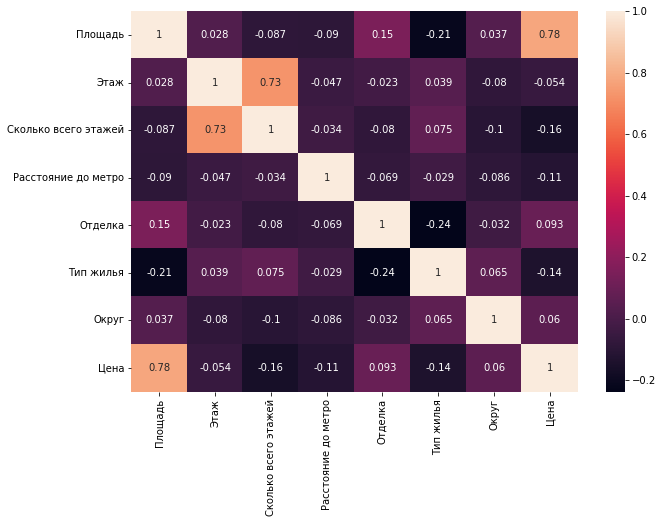

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,7))
sns.heatmap(data.corr(), annot=True)
plt.show()

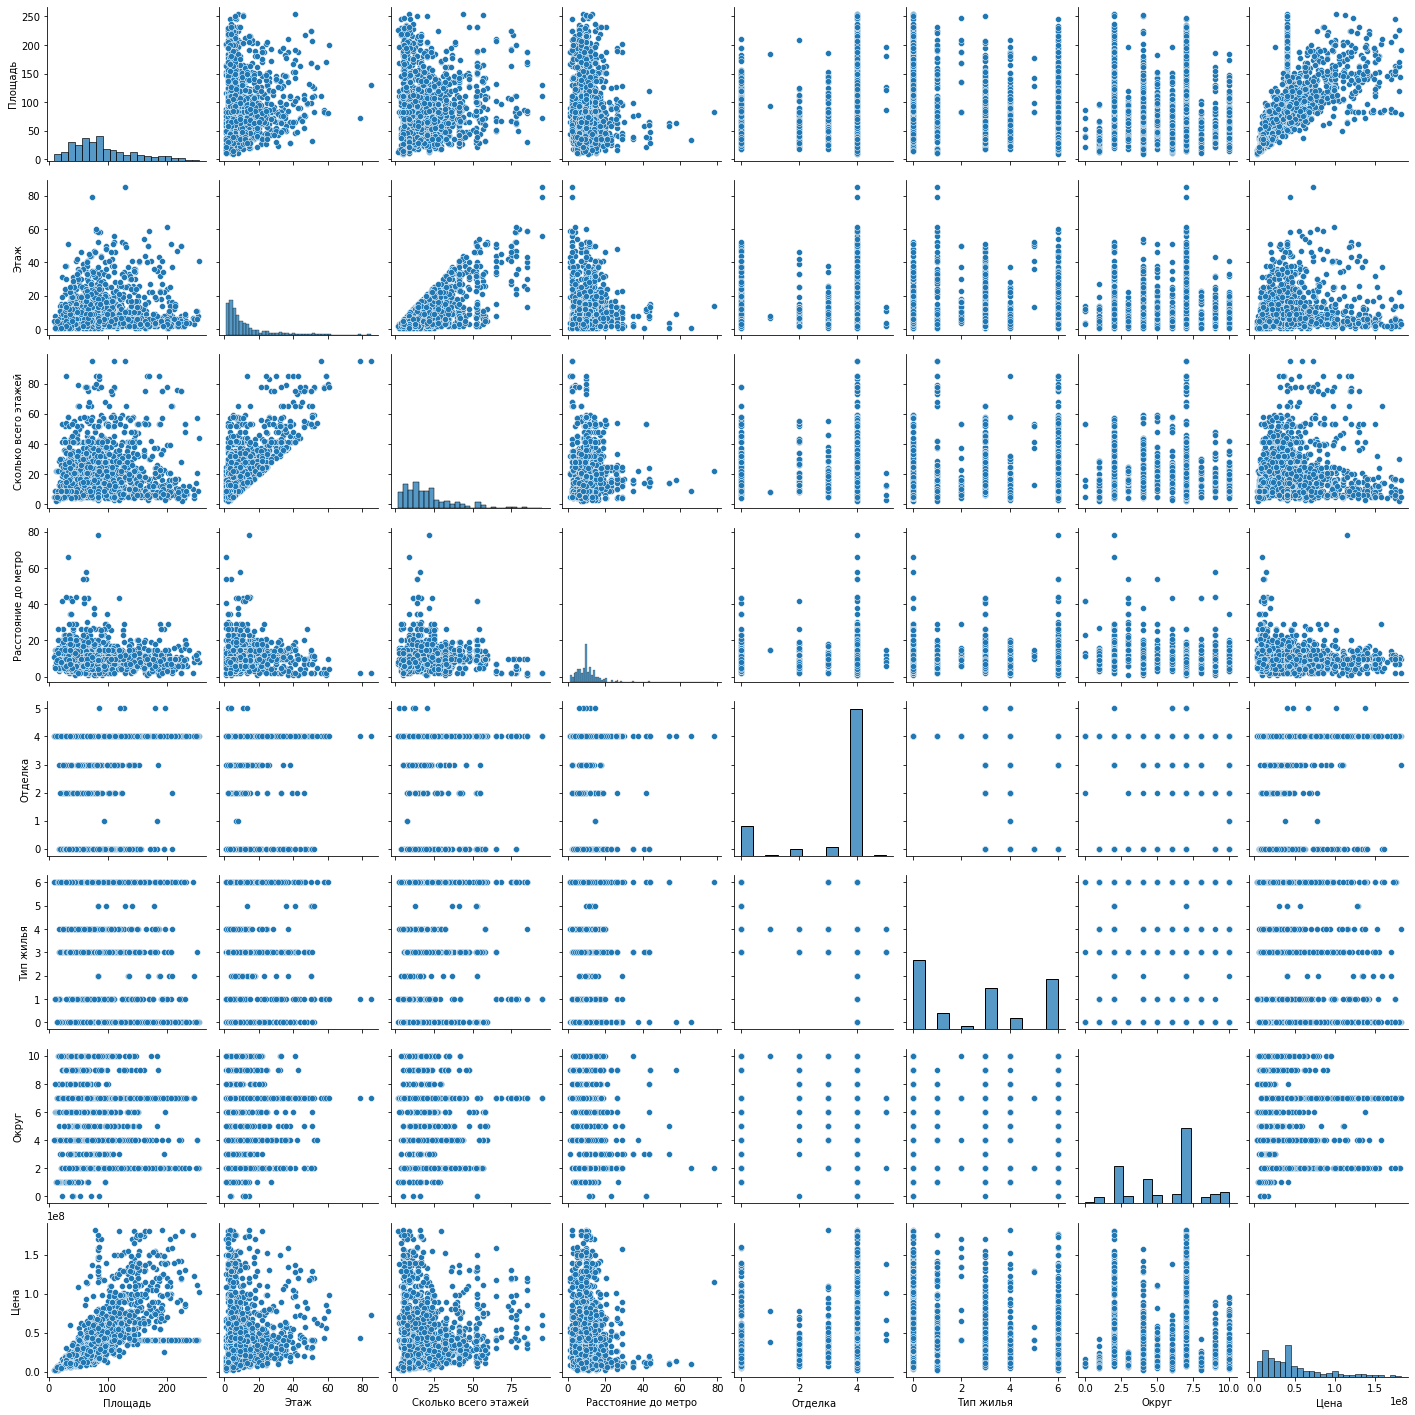

In [ ]:
sns.pairplot(df)

3. Построение модели

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

In [ ]:
df = data
df["Цена"] = (df["Цена"]-df["Цена"].min())/(df["Цена"].max()-df["Цена"].min())
df["Площадь"] = (df["Площадь"]-df["Площадь"].min())/(df["Площадь"].max()-df["Площадь"].min())

In [ ]:
df

,Площадь,Этаж,Сколько всего этажей,Расстояние до метро,Отделка,Тип жилья,Округ,Цена
0,0.091047,6,8,4.0,4,0,7,0.012285
1,0.100217,1,8,5.0,4,3,7,0.046118
2,0.029782,23,30,4.0,4,3,2,0.005097
3,0.151555,5,7,2.0,4,6,7,0.042915
4,0.062400,5,8,5.0,4,0,7,0.008285
...,...,...,...,...,...,...,...,...
1470,0.091425,5,58,10.0,0,4,6,0.007738
1471,0.018247,13,15,44.0,4,6,9,0.002549
1472,0.119854,20,20,15.0,0,3,10,0.021998
1473,0.137468,3,13,8.0,0,6,7,0.027441


In [ ]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
result = sm.OLS(y, x).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.716
Method:                 Least Squares   F-statistic:                              531.9
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:35:01   Log-Likelihood:                          3364.8
No. Observations:                1473   AIC:                                     -6716.
Df Residuals:                    1466   BIC:                                     -6678.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
white_test = het_white(result.resid,  result.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, white_test)))

{'Test Statistic': 1334.9398915098984, 'Test Statistic p-value': 6.350556365107344e-258, 'F-Statistic': 396.99242910091016, 'F-Test p-value': 0.0}


In [ ]:
x = df[["Площадь", "Сколько всего этажей", "Расстояние до метро", "Отделка"]].values

In [ ]:
result = sm.OLS(y, x).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.717
Model:                            OLS   Adj. R-squared (uncentered):              0.717
Method:                 Least Squares   F-statistic:                              932.0
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:07:10   Log-Likelihood:                          3364.3
No. Observations:                1473   AIC:                                     -6721.
Df Residuals:                    1469   BIC:                                     -6699.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
x = sm.add_constant(x)

In [ ]:
result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     608.9
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          7.94e-310
Time:                        15:12:46   Log-Likelihood:                 3365.4
No. Observations:                1473   AIC:                            -6721.
Df Residuals:                    1468   BIC:                            -6694.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.002     -1.500      0.1